In [1]:
import torch.nn as nn
import torch.cuda
from torchvision.utils import save_image
import os
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_PATH = "dataset/"
MODEL_PATH = "models/"
IMAGE_SAVE_PATH = "generated/"

In [3]:
def plotRandomImg(image_paths, num_images = 5):
    random_paths = random.sample(image_paths, num_images)

    # Display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_path in enumerate(random_paths):
        img = mpimg.imread(os.path.join(DATASET_PATH, img_path))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(os.path.basename(img_path))

    plt.show()

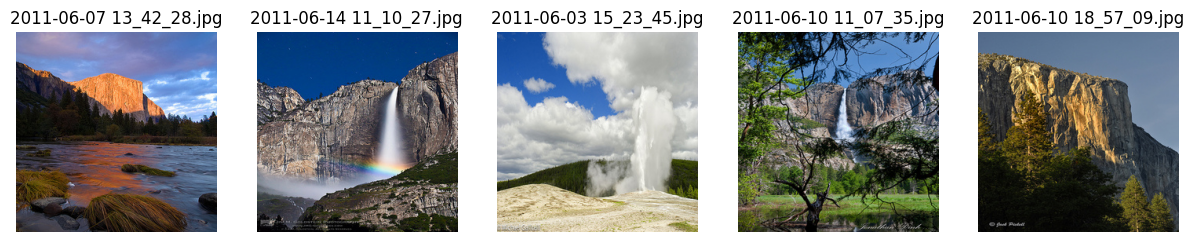

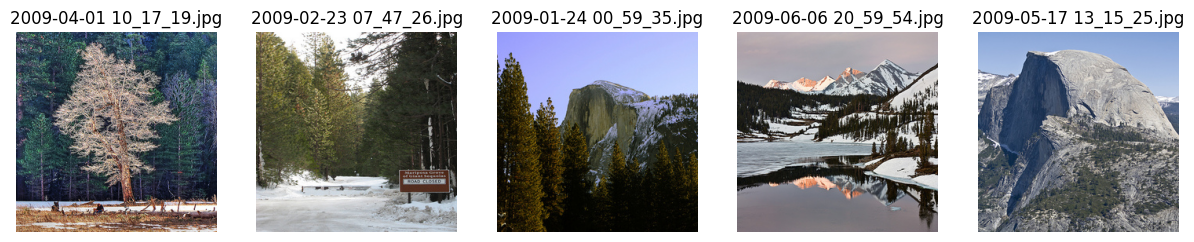

In [4]:
dfA = os.listdir(DATASET_PATH+"A")
dfB = os.listdir(DATASET_PATH+"B")

modified_paths_dfA = []
for img_path in dfA:
    modified_path = os.path.join("A", img_path)  # Add "_modified" to each path
    modified_paths_dfA.append(modified_path)

modified_paths_dfB = []
for img_path in dfB:
    modified_path = os.path.join("B", img_path)    # Add "_modified" to each path
    modified_paths_dfB.append(modified_path)

plotRandomImg(modified_paths_dfA)
plotRandomImg(modified_paths_dfB)

# Model generátora

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.main(x)


class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(DeconvBlock, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.main(x)


class ResBlock(nn.Module):
    # residual block
    def __init__(self, in_channels):
        super(ResBlock, self).__init__()
        self.main = nn.Sequential(
            ConvBlock(in_channels, in_channels, kernel_size=3, padding=1),
            ConvBlock(in_channels, in_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.main(x)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            ConvBlock(3, 64, kernel_size=7, padding=3),

            # downsample
            ConvBlock(64, 128, kernel_size=3, stride=2, padding=1),
            ConvBlock(128, 256, kernel_size=3, stride=2, padding=1),

            # 9 residual blocks
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),

            # upsample
            DeconvBlock(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            DeconvBlock(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),

            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

        )

    def forward(self, x):
        return self.main(x)

# Model klasifikátora - Diskriminator

In [6]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, stride):
        super(Block, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),

            Block(64, 128, 2),
            Block(128, 256, 2),
            Block(256, 512, 1),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Štruktúra pre dataloader

In [7]:
class ImageDataset(Dataset):
    # custom dataset class for dataloader
    def __init__(self, root_a, root_b):
        self.images_a = os.listdir(root_a)
        self.images_a_len = len(self.images_a)
        self.root_a = root_a

        self.images_b = os.listdir(root_b)
        self.images_b_len = len(self.images_b)
        self.root_b = root_b
        self.dataset_len = max(self.images_a_len, self.images_b_len)


        # for training
        self.preprocess  = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, index):
        path_a = os.path.join(self.root_a, self.images_a[index % self.images_a_len])
        image_a = Image.open(path_a).convert("RGB")
        image_a = self.preprocess(image_a)

        path_b = os.path.join(self.root_b, self.images_b[index % self.images_b_len])
        image_b = Image.open(path_b).convert("RGB")
        image_b = self.preprocess(image_b)

        return image_a, image_b


# Trénovací cyklus

In [8]:
def train(loader, disc1, disc2, gen1, gen2, disc_opt, gen_opt, parameters):
    l1 = nn.L1Loss()
    mse = nn.MSELoss()

    fake_photo = None
    fake_paint = None
    num_epochs = parameters["N_EPOCHS"]

    disc1.train()
    disc2.train()
    gen1.train()
    gen2.train()

    for epoch in range(num_epochs):
      for paint, photo in tqdm(loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
          paint = paint.to(DEVICE)
          photo = photo.to(DEVICE)

          fake_paint = gen1(photo)
          fake_photo = gen2(paint)

          # cycle loss
          cycle_paint = gen1(fake_photo)
          cycle_photo = gen2(fake_paint)
          c1_loss = l1(paint, cycle_paint)
          c2_loss = l1(photo, cycle_photo)

          # train discriminators
          d1_real = disc1(paint)
          d1_fake = disc1(fake_paint.detach())
          d1_real_l = mse(d1_real, torch.ones_like(d1_real))
          d1_fake_l = mse(d1_fake, torch.zeros_like(d1_fake))
          d1_l = (d1_real_l + d1_fake_l)/2

          d2_real = disc2(photo)
          d2_fake = disc2(fake_photo.detach())
          d2_real_l = mse(d2_real, torch.ones_like(d2_real))
          d2_fake_l = mse(d2_fake, torch.zeros_like(d2_fake))
          d2_l = (d2_real_l + d2_fake_l)/2

          d_loss = d1_l + d2_l
          disc_opt.zero_grad()
          d_loss.backward()
          disc_opt.step()

          # train generators
          d1_fake = disc1(fake_paint)
          d2_fake = disc2(fake_photo)
          g1_loss = mse(d1_fake, torch.ones_like(d1_fake))
          g2_loss = mse(d2_fake, torch.ones_like(d2_fake))

          g_loss = g1_loss + g2_loss + ((c1_loss + c2_loss) * parameters["LAMBDA_CYCLE"])

          gen_opt.zero_grad()
          g_loss.backward()
          gen_opt.step()


      if fake_photo is not None and fake_paint is not None:
        save_image(fake_paint * 0.5 + 0.5, os.path.join(IMAGE_SAVE_PATH, f"imgA_{epoch + 1}.png"))
        save_image(fake_photo * 0.5 + 0.5, os.path.join(IMAGE_SAVE_PATH, f"imgB_{epoch + 1}.png"))

# Utils

In [9]:
def save(model, optimizer, path):
    savefile = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(savefile, path)


def load(model, optimizer, learning_rate, path):
    if DEVICE == "cuda":
       savefile = torch.load(path)
    else:
        savefile = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(savefile["model"])


    for param_group in optimizer.param_groups:
        param_group["lr"] = learning_rate

# Hyperparametre a inicializácia

In [10]:
params = {
    "BATCH_SIZE": 2,
    "LEARNING_RATE": 0.0002,
    "N_EPOCHS": 2,
    "LAMBDA_CYCLE": 10
}

In [11]:
# other datasets: http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/

dataset = ImageDataset(DATASET_PATH+"/A", root_b=DATASET_PATH+"/B")
loader = DataLoader(dataset, batch_size=params["BATCH_SIZE"], shuffle=True)

disc1 = Discriminator().to(DEVICE)
disc2 = Discriminator().to(DEVICE)
gen1 = Generator().to(DEVICE)
gen2 = Generator().to(DEVICE)

disc_opt = optim.Adam(list(disc1.parameters())+list(disc2.parameters()), lr=params["LEARNING_RATE"], betas=(0.5, 0.999))
gen_opt = optim.Adam(list(gen1.parameters())+list(gen2.parameters()), lr=params["LEARNING_RATE"], betas=(0.5, 0.999))


# Trénovanie

In [12]:
train(loader, disc1, disc2, gen1, gen2, disc_opt, gen_opt, params)

Epoch 1/2: 100%|██████████| 13/13 [01:49<00:00,  8.42s/it]



Saving image


Epoch 2/2: 100%|██████████| 13/13 [01:47<00:00,  8.24s/it]


Saving image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


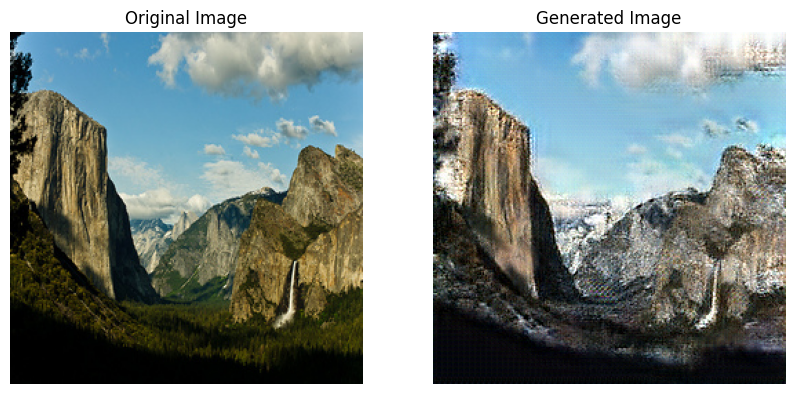

In [13]:
img_path = "dataset/A/2011-05-30 18_05_07.jpg"

gen = Generator().to(DEVICE)
load(gen, gen_opt,0.002, path=MODEL_PATH+"/gen2.pth")
gen.eval()

preprocess  = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

img = Image.open(img_path).convert("RGB")
img = preprocess(img)

output = gen(img)

generated_image = output.squeeze().detach().cpu()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(img_path))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_image.permute(1, 2, 0) * 0.5 + 0.5)
plt.title('Generated Image')
plt.axis('off')

plt.show()